In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Define the directory and file pattern
data_dir = Path("../data/BACI_HS92_V202501")
years = range(1995, 2024)
# years = range(1995, 2000)
file_pattern = "BACI_HS92_Y{}_V202501.csv"

# Collect DataFrames
dfs = []
for year in years:
    file_path = data_dir / file_pattern.format(year)
    if file_path.exists():
        df = pd.read_csv(file_path)
        dfs.append(df)
    else:
        print(f"Warning: {file_path} does not exist.")

# Vertically stack (concatenate) all DataFrames
baci = pd.concat(dfs, ignore_index=True)

In [11]:
baci.head()

,t,i,j,k,v,q
0,1995,4,12,841510,36.687,5.812
1,1995,4,20,570110,11.060,0.195
2,1995,4,36,80620,12.865,15.000
3,1995,4,36,570110,11.931,0.245
4,1995,4,36,570210,3.701,0.377


In [12]:
baci.shape

(258605562, 6)

In [13]:
# Take a random subsample of baci
# Set random seed for reproducibility
np.random.seed(42)

# Define subsample size (adjust as needed)
subsample_size = 1000000  # You can adjust this number based on your needs

# Take random subsample
baci = baci.sample(n=subsample_size, random_state=42)

In [14]:
# Save the subsample to a new CSV file

baci.to_csv('../data/baci_subsample.csv', index=False)

In [15]:
baci.shape

(1000000, 6)

In [16]:

def epanechnikov_kernel(u):
    """Epanechnikov kernel function"""
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)

def time_varying_variance(data, bandwidth=None):
    """
    Calculate time-varying variance using Epanechnikov kernel
    
    Parameters:
    data: DataFrame with columns ['t', 'v'] for a specific (i, k)
    bandwidth: kernel bandwidth (if None, uses optimal bandwidth based on Silverman's rule)
    """
    data = data.sort_values('t').reset_index(drop=True)
    time_points = data['t'].values
    v_values = data['v'].values
    n = len(data)
    
    # Calculate optimal bandwidth if not provided (Silverman's rule for Epanechnikov kernel)
    if bandwidth is None:
        # For Epanechnikov kernel, optimal bandwidth ≈ 2.34 * std * n^(-1/5)
        time_std = np.std(time_points)
        bandwidth = 2.34 * time_std * (n ** (-0.2))
        # Ensure minimum bandwidth of 0.5 for very small datasets
        bandwidth = max(bandwidth, 0.5)
    
    variances = []
    
    for idx in range(n):
        current_time = time_points[idx]
        
        # Calculate kernel weights for all observations
        u = (time_points - current_time) / bandwidth
        weights = epanechnikov_kernel(u)
        
        # Only use observations with non-zero weights
        valid_weights = weights > 0
        if np.sum(valid_weights) > 1:  # Need at least 2 points for variance
            weighted_v = v_values[valid_weights]
            w = weights[valid_weights]
            w = w / np.sum(w)  # Normalize weights
            
            # Calculate weighted variance
            weighted_mean = np.sum(w * weighted_v)
            weighted_var = np.sum(w * (weighted_v - weighted_mean)**2)
            variances.append(weighted_var)
        else:
            variances.append(np.nan)
    
    return np.array(variances)

# Calculate time-varying variance for each (i,k) combination in baci
variance_results = []
total_combinations = len(baci.groupby(['i', 'k']))

for idx, ((i_val, k_val), group) in enumerate(baci.groupby(['i', 'k'])):
    if idx % 1000 == 0:  # Progress indicator
        print(f"Processing i={i_val}, k={k_val} ({idx}/{total_combinations})")
    
    # Use 'v' column for variance calculation (trade values)
    group_sorted = group.sort_values('t').copy()
    
    if len(group_sorted) > 1:  # Need at least 2 observations
        group_sorted['var_ik'] = time_varying_variance(group_sorted[['t', 'v']])
        variance_results.append(group_sorted)

# Combine results
baci_with_variance = pd.concat(variance_results, ignore_index=True)

print(f"Shape of data with time-varying variance: {baci_with_variance.shape}")
print(f"Number of unique (i,k) combinations processed: {baci_with_variance.groupby(['i', 'k']).ngroups}")
print(f"Columns: {list(baci_with_variance.columns)}")
baci_with_variance.head(10)

Processing i=4, k=10119 (0/273126)
Processing i=12, k=401290 (1000/273126)
Processing i=24, k=841480 (2000/273126)
Processing i=31, k=950659 (3000/273126)
Processing i=32, k=521132 (4000/273126)
Processing i=32, k=853225 (5000/273126)
Processing i=32, k=521132 (4000/273126)
Processing i=32, k=853225 (5000/273126)
Processing i=36, k=284390 (6000/273126)
Processing i=36, k=284390 (6000/273126)
Processing i=36, k=610419 (7000/273126)
Processing i=36, k=843041 (8000/273126)
Processing i=36, k=610419 (7000/273126)
Processing i=36, k=843041 (8000/273126)
Processing i=40, k=40310 (9000/273126)
Processing i=40, k=40310 (9000/273126)
Processing i=40, k=370294 (10000/273126)
Processing i=40, k=370294 (10000/273126)
Processing i=40, k=620429 (11000/273126)
Processing i=40, k=620429 (11000/273126)
Processing i=40, k=843020 (12000/273126)
Processing i=40, k=843020 (12000/273126)
Processing i=44, k=240220 (13000/273126)
Processing i=48, k=854420 (14000/273126)
Processing i=50, k=852190 (15000/273126

,t,i,j,k,v,q,var_ik
0,2010,4,792,50400,401.041,15.872,3.815454e+03
1,2023,4,422,50400,64.123,8.813,3.815454e+03
2,2016,4,792,80212,338.023,46.948,6.628157e+02
3,2018,4,682,80212,286.272,40.528,1.029794e+04
4,2022,4,586,80212,602.889,377.149,1.682506e+04
5,2018,4,36,80232,3.086,0.445,3.167922e-03
6,2023,4,752,80232,3.393,0.604,3.167922e-03
7,2011,4,124,80250,17.250,1.020,1.804016e+06
8,2013,4,792,80250,2920.367,237.802,1.560911e+06
9,2017,4,784,80250,1219.773,133.009,1.250414e+06


In [17]:
# Calculate the variance of v at each time t
dispersion = baci.groupby('t')['v'].var().reset_index()
dispersion = dispersion.rename(columns={'v': 'var_t'})

print(f"Shape of variance by time data: {dispersion.shape}")
print(f"Time period range: {dispersion['t'].min()} to {dispersion['t'].max()}")
dispersion.head(10)

Shape of variance by time data: (29, 2)
Time period range: 1995 to 2023


,t,var_t
0,1995,6.178439e+07
1,1996,3.637091e+08
2,1997,3.972410e+08
3,1998,2.711559e+08
4,1999,1.524807e+08
5,2000,6.206949e+08
6,2001,3.802720e+09
7,2002,2.444609e+08
8,2003,3.803023e+08
9,2004,1.328216e+09


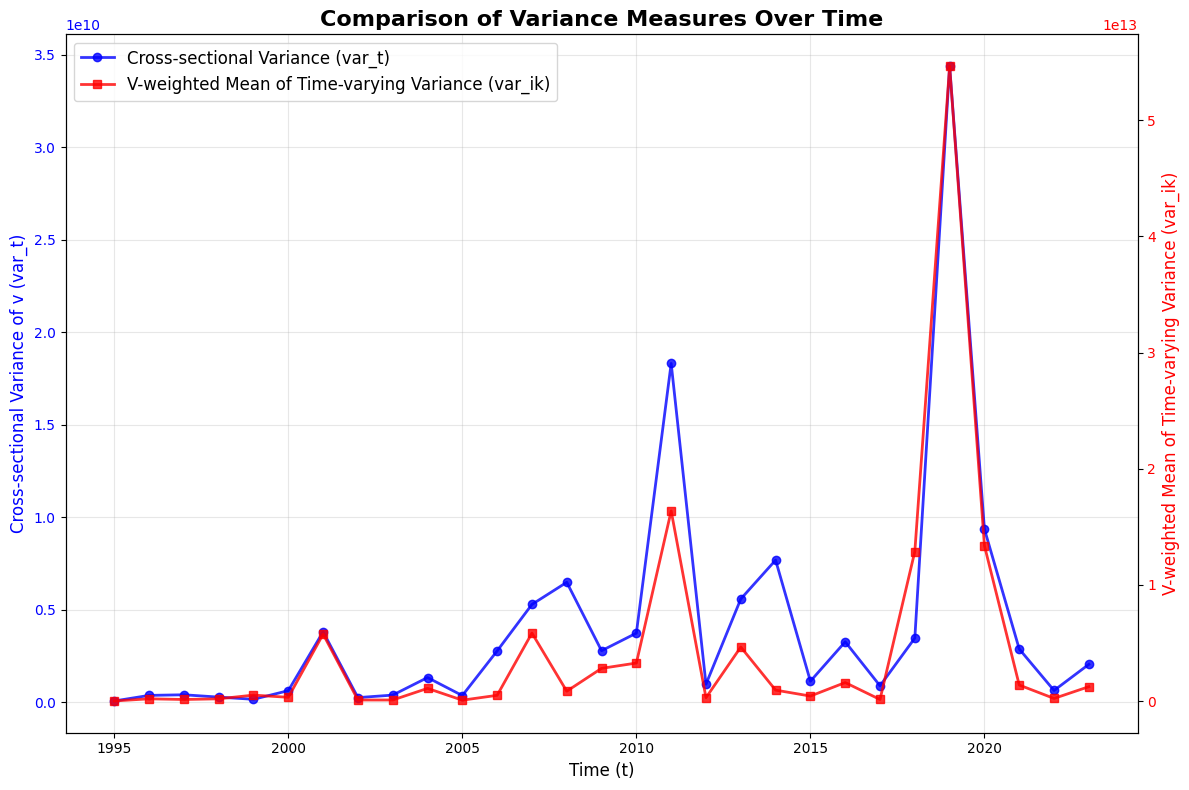

Plot saved to ../figures/variance_comparison_dual_axes.png and .pdf
Summary Statistics:
var_t - Mean: 4.12e+09, Std: 6.96e+09
Weighted var_ik - Mean: 4.48e+12, Std: 1.06e+13
Correlation between var_t and weighted var_ik: 0.941

Weighted var_ik data shape: (29, 2)


,t,weighted_var_ik
0,1995,4.450862e+09
1,1996,1.910208e+11
2,1997,1.320222e+11
3,1998,1.903604e+11
4,1999,5.094844e+11


In [18]:
# Calculate weighted mean of var_ik by time t, using v as weights
def calculate_weighted_var_ik():
    # Remove rows with missing var_ik
    valid_data = baci_with_variance.dropna(subset=['var_ik'])
    
    weighted_var_ik_by_time = []
    for t_val in sorted(valid_data['t'].unique()):
        t_data = valid_data[valid_data['t'] == t_val]
        
        # Calculate weighted mean using v values as weights
        weights = t_data['v']
        weighted_mean = np.average(t_data['var_ik'], weights=weights)
        
        weighted_var_ik_by_time.append({'t': t_val, 'weighted_var_ik': weighted_mean})
    
    return pd.DataFrame(weighted_var_ik_by_time)

weighted_var_ik = calculate_weighted_var_ik()

# Create plot with dual y-axes
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Plot var_t on left y-axis
color1 = 'blue'
ax1.set_xlabel('Time (t)', fontsize=12)
ax1.set_ylabel('Cross-sectional Variance of v (var_t)', color=color1, fontsize=12)
line1 = ax1.plot(dispersion['t'], dispersion['var_t'], 
                 linewidth=2, color=color1, marker='o', markersize=6, 
                 label='Cross-sectional Variance (var_t)', alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for weighted var_ik
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('V-weighted Mean of Time-varying Variance (var_ik)', color=color2, fontsize=12)
line2 = ax2.plot(weighted_var_ik['t'], weighted_var_ik['weighted_var_ik'], 
                 linewidth=2, color=color2, marker='s', markersize=6, 
                 label='V-weighted Mean of Time-varying Variance (var_ik)', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legend
ax1.set_title('Comparison of Variance Measures Over Time', fontsize=16, fontweight='bold')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=12)

# Save the plot
from pathlib import Path
figures_dir = Path("../figures")
figures_dir.mkdir(exist_ok=True)

plt.tight_layout()
plt.savefig(figures_dir / "variance_comparison_dual_axes.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Plot saved to {figures_dir}/variance_comparison_dual_axes.png and .pdf")

# Summary statistics
print("Summary Statistics:")
print(f"var_t - Mean: {dispersion['var_t'].mean():.2e}, Std: {dispersion['var_t'].std():.2e}")
print(f"Weighted var_ik - Mean: {weighted_var_ik['weighted_var_ik'].mean():.2e}, Std: {weighted_var_ik['weighted_var_ik'].std():.2e}")

# Calculate correlation
merged_data = dispersion.merge(weighted_var_ik, on='t')
correlation = merged_data['var_t'].corr(merged_data['weighted_var_ik'])
print(f"Correlation between var_t and weighted var_ik: {correlation:.3f}")

# Display the weighted variance data
print(f"\nWeighted var_ik data shape: {weighted_var_ik.shape}")
weighted_var_ik.head()